This is loosely based on https://smorabit.github.io/tutorials/8_velocyto/

In [3]:
import scvelo as scv
import pandas as pd
import numpy as np
import anndata
import os

In [6]:
loom_dir = 'RNA_velocity/'
data_dir = 'exported_matrices/'

datasets = pd.read_csv("datasets.csv", index_col=None)


def convert_to_AnnData(dataset: str, verbose: bool = True) -> anndata.AnnData:
    """ 
    Loads the velocity data for a given dataset.

    Parameters
    ----------
    dataset : str
        The dataset to load.
    verbose : bool
        Whether to print out progress information, defaults to True.

    Returns
    -------
    adata : anndata.AnnData
        The AnnData object containing the expression and velocity data.    
    """

    # Start by merging the loom files
    filtered_datasets = datasets[datasets['study_id'] == dataset]
    loom_filenames = [f"{row['study_id']}_{row['source']}" for _,
                      row in filtered_datasets.iterrows()]

    # Read dataset information
    metadata = pd.read_csv(f"{data_dir}{dataset}_metadata.csv", index_col=None)
    pca = pd.read_csv(f"{data_dir}/{dataset}_pca.csv", index_col=None)
    umap = pd.read_csv(f"{data_dir}/{dataset}_umap.csv", index_col=None)
    clusters = pd.read_csv(
        f"{data_dir}/{dataset}_clusters.csv", index_col=None)
    counts = pd.read_csv(
        f"{data_dir}{dataset}_counts.csv", index_col=0)
    gene_names = counts.index.values
    
    vel_data = None
    num_removed = 0

    for i, filename in enumerate(loom_filenames):
        if verbose:
            print(f"Loading {filename}.loom")
        if i == 0:
            vel_data = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data, id_length=16, alphabet="[ACGT]", inplace=True)
            vel_data.var_names_make_unique()

            # Only select common genes
            vel_data = vel_data[:, gene_names]
        else:
            vel_data2 = scv.read(f"{loom_dir}{filename}.loom", cache=False)
            scv.utils.clean_obs_names(
                vel_data2, id_length=16, alphabet="[ACGT]", inplace=True)

            common_barcodes = np.intersect1d(
                vel_data.obs.index, vel_data2.obs.index)

            # Remove barcodes that are in both datasets from the second dataset, otherwise scv.utils.merge will fail
            # This is not perfect, but it's a very small number of barcodes
            vel_data2 = vel_data2[~vel_data2.obs.index.isin(common_barcodes)]
            num_removed += len(common_barcodes)

            vel_data2.var_names_make_unique()
            vel_data2 = vel_data2[:, gene_names]
            vel_data = vel_data.concatenate(vel_data2, index_unique=None)


    if verbose:
        print(f"Removed {num_removed} barcodes that were in multiple datasets")
        print(f"Final shape: {vel_data.shape}")

    # Add metadata and dimensionality reductions
    
    vel_barcodes = vel_data.obs.index
    vel_data.var.index = gene_names

    pca['Barcode'] = [x.split('-')[0] for x in pca['Barcode']]
    pca = pca.drop_duplicates(subset=['Barcode'])
    pca = pca[pca['Barcode'].isin(vel_barcodes)]
    pca = pca.set_index('Barcode', drop=True)
    pca = pca.reindex(vel_barcodes)

    umap['Barcode'] = [x.split('-')[0] for x in umap['Barcode']]
    umap = umap.drop_duplicates(subset=['Barcode'])
    umap = umap[umap['Barcode'].isin(vel_barcodes)]
    umap = umap.set_index('Barcode', drop=True)
    umap = umap.reindex(vel_barcodes)

    clusters['Barcode'] = [x.split('-')[0] for x in clusters['Barcode']]
    clusters = clusters.drop_duplicates(subset=['Barcode'])
    clusters = clusters[clusters['Barcode'].isin(vel_barcodes)]
    clusters = clusters.set_index('Barcode', drop=True)
    clusters = clusters.reindex(vel_barcodes)

    vel_data.obsm['X_pca'] = pca
    vel_data.obsm['X_umap'] = np.vstack(
        (umap['UMAP_1'].values, umap['UMAP_2'].values)).T
    vel_data.obs["cluster"] = [f"C{c}" for c in clusters['Cluster']]
    vel_data.obs["cluster"] = vel_data.obs["cluster"].astype("category")

    return vel_data

Processing Ruf_Zamojski2021F
Loading Ruf_Zamojski2021F_SRR11945353.loom
Loading Ruf_Zamojski2021F_SRR11945364.loom
Loading Ruf_Zamojski2021F_SRR11945365.loom
Loading Ruf_Zamojski2021F_SRR11945366.loom
Removed 1582 barcodes that were in multiple datasets
Final shape: (1584, 11103)
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1584 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021F_velocity_umap_stream.png


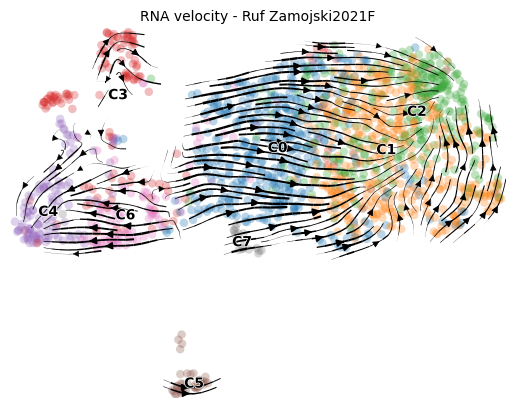

Processing Ruf_Zamojski2021M
Loading Ruf_Zamojski2021M_SRR11945354.loom
Loading Ruf_Zamojski2021M_SRR11945355.loom
Loading Ruf_Zamojski2021M_SRR11945356.loom
Loading Ruf_Zamojski2021M_SRR11945357.loom
Loading Ruf_Zamojski2021M_SRR11945358.loom
Loading Ruf_Zamojski2021M_SRR11945359.loom
Loading Ruf_Zamojski2021M_SRR11945360.loom
Loading Ruf_Zamojski2021M_SRR11945361.loom
Loading Ruf_Zamojski2021M_SRR11945362.loom
Loading Ruf_Zamojski2021M_SRR11945363.loom
Removed 1355 barcodes that were in multiple datasets
Final shape: (1360, 11103)
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:0

  0%|          | 0/1360 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Ruf_Zamojski2021M_velocity_umap_stream.png


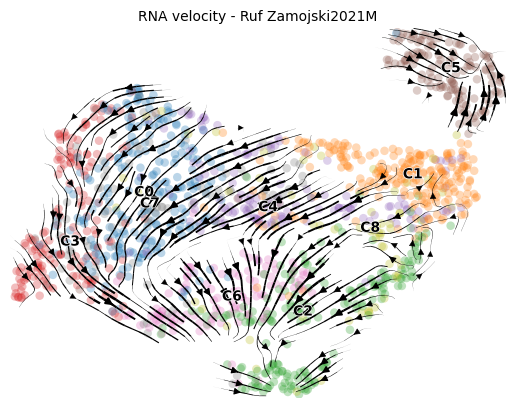

Processing Lopez2021M
Loading Lopez2021M_SRR13081817.loom
Removed 0 barcodes that were in multiple datasets
Final shape: (354, 11103)
saving figure to file plots/RNA_velocity/Lopez2021M_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/354 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Lopez2021M_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Lopez2021M_velocity_umap_stream.png


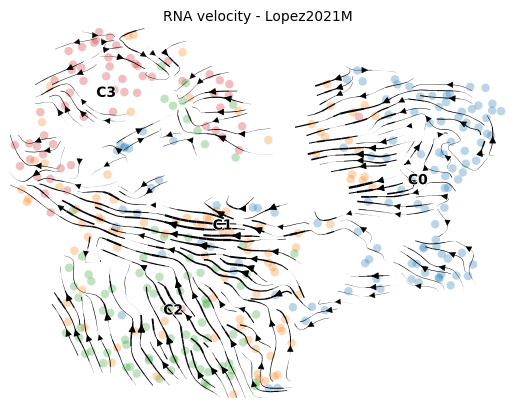

Processing Allensworth2021F
Loading Allensworth2021F_SRR12074650.loom
Loading Allensworth2021F_SRR12074651.loom
Loading Allensworth2021F_SRR12074652.loom
Loading Allensworth2021F_SRR12074653.loom
Loading Allensworth2021F_SRR12074654.loom
Loading Allensworth2021F_SRR12074655.loom
Loading Allensworth2021F_SRR12074656.loom
Loading Allensworth2021F_SRR12074657.loom
Removed 939 barcodes that were in multiple datasets
Final shape: (313, 11103)
saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computin

  0%|          | 0/313 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Allensworth2021F_velocity_umap_stream.png


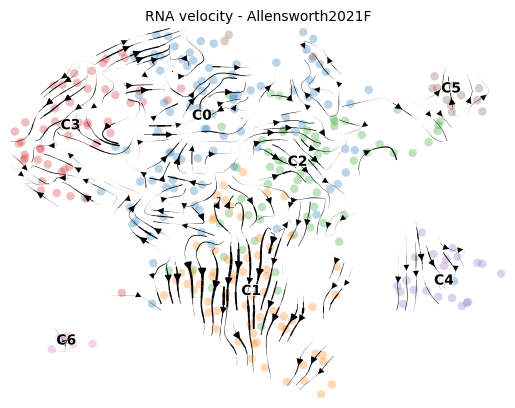

Processing Vennekens2021M
Loading Vennekens2021M_scrEXT036.loom
Loading Vennekens2021M_scrEXT149.loom
Removed 0 barcodes that were in multiple datasets
Final shape: (541, 11103)
saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/541 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Vennekens2021M_velocity_umap_stream.png


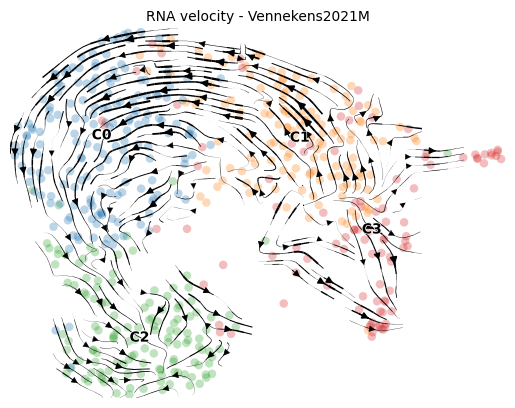

Processing Mayran2019M
Loading Mayran2019M_SRR8487461.loom
Removed 0 barcodes that were in multiple datasets
Final shape: (954, 11103)
saving figure to file plots/RNA_velocity/Mayran2019M_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/954 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Mayran2019M_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Mayran2019M_velocity_umap_stream.png


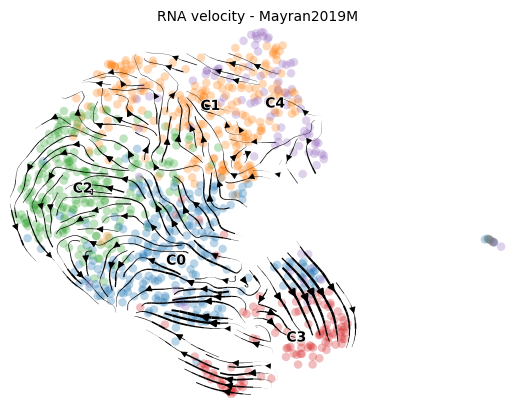

Processing Cheung2018M
Loading Cheung2018M_SRR7898909.loom
Loading Cheung2018M_SRR7898910.loom
Removed 4 barcodes that were in multiple datasets
Final shape: (961, 11103)
saving figure to file plots/RNA_velocity/Cheung2018M_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/961 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Cheung2018M_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Cheung2018M_velocity_umap_stream.png


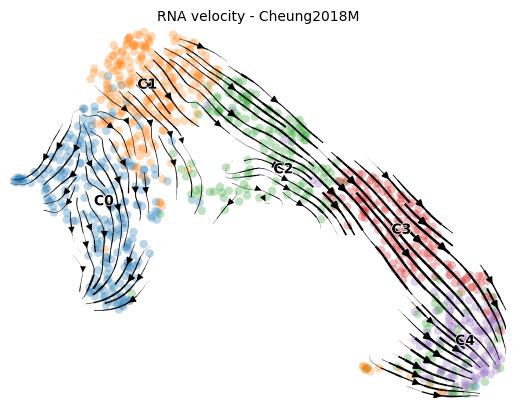

Processing Kucka2021F
Loading Kucka2021F_SRR15926823.loom
Loading Kucka2021F_SRR15926823.loom
Loading Kucka2021F_SRR15926825.loom
Loading Kucka2021F_SRR15926825.loom
Loading Kucka2021F_SRR15926826.loom
Loading Kucka2021F_SRR15926826.loom
Removed 1232 barcodes that were in multiple datasets
Final shape: (1228, 11103)
saving figure to file plots/RNA_velocity/Kucka2021F_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/1228 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Kucka2021F_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Kucka2021F_velocity_umap_stream.png


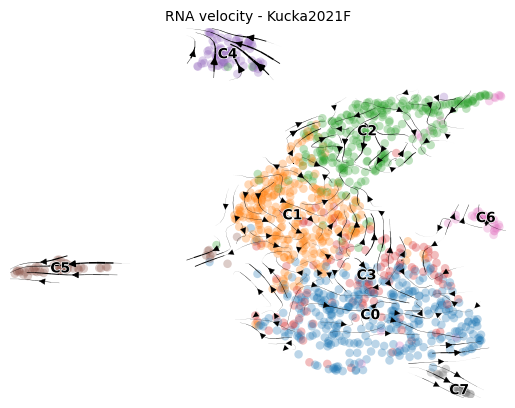

Processing Fletcher2019F
Loading Fletcher2019F_SRR9203724.loom
Loading Fletcher2019F_SRR9203725.loom
Loading Fletcher2019F_SRR9203726.loom
Loading Fletcher2019F_SRR9203727.loom
Removed 391 barcodes that were in multiple datasets
Final shape: (391, 11103)
saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/391 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_umap_grid.png
saving figure to file plots/RNA_velocity/Fletcher2019F_velocity_umap_stream.png


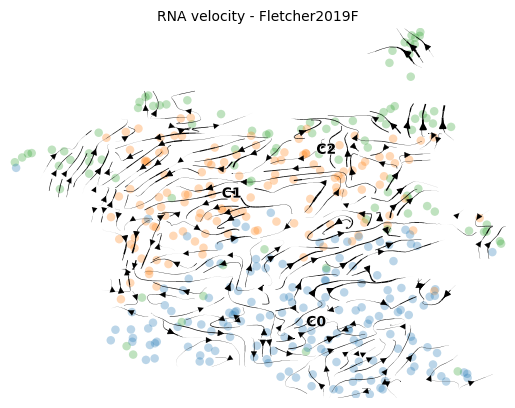

Processing Fletcher2019M
Loading Fletcher2019M_SRR9203728.loom
Loading Fletcher2019M_SRR9203729.loom
Loading Fletcher2019M_SRR9203730.loom
Loading Fletcher2019M_SRR9203731.loom
Removed 548 barcodes that were in multiple datasets
Final shape: (548, 11103)
saving figure to file plots/RNA_velocity/Fletcher2019M_velocity_proportions.png
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


LinAlgError: SVD did not converge

In [9]:
output_dir = 'plots/RNA_velocity/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

for dataset in datasets['study_id'].unique():
    print(f"Processing {dataset}")
    adata = convert_to_AnnData(dataset)
    adata.write(f"{loom_dir}{dataset}_velocity.h5ad")

    scv.pl.proportions(adata, groupby='cluster',
                       show=False, save=f"{output_dir}{dataset}_velocity_proportions.png")

    scv.pp.filter_and_normalize(adata)
    scv.pp.moments(adata)
    scv.tl.velocity(adata, mode='stochastic')
    scv.tl.velocity_graph(adata)
    scv.pl.velocity_embedding_grid(adata, basis='umap', color='cluster', title=f"RNA velocity - {dataset}", scale=0.25,
                                   show=False, save=f"{output_dir}{dataset}_velocity_umap_grid.png")
    scv.pl.velocity_embedding_stream(adata, basis='umap', color=['cluster'], 
                                     size=150, title=f"RNA velocity - {dataset}",
                                     show=True, save=f"{output_dir}{dataset}_velocity_umap_stream.png")